In [9]:
 # - Network 256 512 512 96
 # - EPOCHS = 170
 # - BATCH_SIZE = 8
 # - LEARNING_RATE = 0.001
 # - DROPOUT = 0.06

In [10]:
import pandas as pd
import pickle
from google.cloud import storage
from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud import aiplatform_v1beta1
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import matplotlib.pyplot as plt 

In [11]:
aiplatform.init(location='asia-northeast3')

In [12]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)


In [13]:
download_blob("mlops-test-kay", "airport_passenger/X_val_multi_scaled_nm_ns_7_lt21_tr_nofm.pkl", "X_val_multi_scaled_nm_ns_7_lt21_tr_nofm.pkl")

In [14]:
with open('X_val_multi_scaled_nm_ns_7_lt21_tr_nofm.pkl','rb') as f:
    X_val_multi_scaled = pickle.load(f)

In [15]:
X_val_multi_scaled_list=X_val_multi_scaled.tolist()

In [16]:
aiplatform.init(project='charged-genre-350106', location='asia-northeast3')

endpoint = aiplatform.Endpoint('463413364782006272')

prediction = endpoint.predict(instances=X_val_multi_scaled_list)
print(prediction)

Prediction(predictions=[[0.841892302, 0.793156564, 0.68916, 0.793716609, 0.77223444, 0.783422768, 0.784364], [0.775506258, 0.792724192, 0.771018386, 0.811330438, 0.798005581, 0.728059649, 0.74996686], [0.814371884, 0.860958934, 0.701874852, 0.829070807, 0.776632667, 0.69702208, 0.718761325], [0.871574521, 0.707013905, 0.801899135, 0.763744831, 0.711642742, 0.675710797, 0.601912141], [0.763509512, 0.867340684, 0.786133587, 0.784193516, 0.673698127, 0.604073, 0.632512927], [0.891616344, 0.875084043, 0.70508194, 0.729489803, 0.613055348, 0.595004857, 0.578933239], [0.860064566, 0.751649916, 0.666922271, 0.673394561, 0.706100583, 0.667754114, 0.777825534], [0.801360607, 0.742023945, 0.617779672, 0.734168231, 0.751324534, 0.743956387, 0.640314102], [0.73052609, 0.633158326, 0.703467965, 0.736760616, 0.797270119, 0.561596453, 0.646947443], [0.65912807, 0.672065437, 0.73083818, 0.763638735, 0.653562546, 0.56541431, 0.66800952], [0.675009966, 0.692938626, 0.756590962, 0.709587574, 0.618692636,

## Inverse scaling을 위해 빅쿼리에 있는 tr, ts데이터로 scaling, inverse sclaing

In [17]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data manipulation, visualization and useful functions
import argparse
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing

# gcp functions
from google.cloud import bigquery
from google.cloud import storage
import time
from datetime import datetime, timedelta
import pickle

n_steps=7

# Set up BigQuery & Storage clients
bqclient = bigquery.Client(project='charged-genre-350106')
storage_client = storage.Client(project='charged-genre-350106')

# Query for base dataset
query_tr = """
    SELECT *
    FROM `charged-genre-350106.demand_forecasting.airport_passenger_tr_nm_ns_7_lt21_tr_nofm`
    """

query_vd = """
    SELECT *
    FROM `charged-genre-350106.demand_forecasting.airport_passenger_ts_nm_ns_7_lt21_tr_nofm`
    """

trds = bqclient.query(query_tr).to_dataframe()
tsds = bqclient.query(query_vd).to_dataframe()
trds=trds.sort_values(by='datetime')
tsds=tsds.sort_values(by='datetime')

def datasplit_X_Y(data, Y_colname, X_colname):
    X_colname = [x for x in data.columns if x not in Y_colname + X_remove]
    Y_data = data[Y_colname]
    X_data = data[X_colname]
    print('X:', X_data.shape, 'Y:', Y_data.shape)
    return X_data, Y_data

# Data Split to X and Y
Y_colname = ['count']
X_remove = ['datetime', 'data_split']
X_colname = [x for x in trds.columns if x not in Y_colname]# + X_remove]
X_train, Y_train = datasplit_X_Y(trds, Y_colname, X_colname)
X_val, Y_val = datasplit_X_Y(tsds, Y_colname, X_colname)

continous_feature=[
'ticket_1', 'ticket_2', 'ticket_3','ticket_4','ticket_5','ticket_6','ticket_7',
                    'ticket_8', 'ticket_9', 'ticket_10','ticket_11','ticket_12','ticket_13','ticket_14',
                    'ticket_15','ticket_16', 'ticket_17','ticket_18','ticket_19','ticket_20','ticket_21',
                    'fare_min_1','fare_min_2','fare_min_3','fare_min_4','fare_min_5','fare_min_6','fare_min_7',
                    'fare_min_8','fare_min_9','fare_min_10','fare_min_11','fare_min_12','fare_min_13','fare_min_14',
                    'fare_min_15','fare_min_16','fare_min_17','fare_min_18','fare_min_19','fare_min_20','fare_min_21', 
                    'fare_max_1','fare_max_2','fare_max_3','fare_max_4','fare_max_5','fare_max_6','fare_max_7',
                    'fare_max_8','fare_max_9','fare_max_10','fare_max_11','fare_max_12','fare_max_13','fare_max_14',
                    'fare_max_15','fare_max_16','fare_max_17','fare_max_18','fare_max_19','fare_max_20','fare_max_21',
                    'fare_avg_1','fare_avg_2','fare_avg_3','fare_avg_4','fare_avg_5','fare_avg_6','fare_avg_7',
                    'fare_avg_8','fare_avg_9','fare_avg_10','fare_avg_11','fare_avg_12','fare_avg_13','fare_avg_14',
                    'fare_avg_15','fare_avg_16','fare_avg_17','fare_avg_18','fare_avg_19','fare_avg_20','fare_avg_21',
                    'fare_std_1','fare_std_2','fare_std_3','fare_std_4','fare_std_5','fare_std_6','fare_std_7',
                    'fare_std_8','fare_std_9','fare_std_10','fare_std_11','fare_std_12','fare_std_13','fare_std_14',
                    'fare_std_15','fare_std_16','fare_std_17','fare_std_18','fare_std_19','fare_std_20','fare_std_21',
                    'seat_min_1','seat_min_2','seat_min_3','seat_min_4','seat_min_5','seat_min_6','seat_min_7',
                    'seat_min_8','seat_min_9','seat_min_10','seat_min_11','seat_min_12','seat_min_13','seat_min_14',
                    'seat_min_15','seat_min_16','seat_min_17','seat_min_18','seat_min_19','seat_min_20','seat_min_21',
                    'seat_max_1','seat_max_2','seat_max_3','seat_max_4','seat_max_5','seat_max_6','seat_max_7',
                    'seat_max_8','seat_max_9','seat_max_10','seat_max_11','seat_max_12','seat_max_13','seat_max_14',
                    'seat_max_15','seat_max_16','seat_max_17','seat_max_18','seat_max_19','seat_max_20','seat_max_21',
                    'seat_avg_1','seat_avg_2','seat_avg_3','seat_avg_4','seat_avg_5','seat_avg_6','seat_avg_7',
                    'seat_avg_8','seat_avg_9','seat_avg_10','seat_avg_11','seat_avg_12','seat_avg_13','seat_avg_14',
                    'seat_avg_15','seat_avg_16','seat_avg_17','seat_avg_18','seat_avg_19','seat_avg_20','seat_avg_21',
                    'seat_std_1','seat_std_2','seat_std_3','seat_std_4','seat_std_5','seat_std_6','seat_std_7',
                    'seat_std_8','seat_std_9','seat_std_10','seat_std_11','seat_std_12','seat_std_13','seat_std_14',
                    'seat_std_15','seat_std_16','seat_std_17','seat_std_18','seat_std_19','seat_std_20','seat_std_21',
                    'b_1','b_2','b_3','b_4','b_5','b_6','b_7','b_8','b_9','b_10','b_11','b_12','b_13','b_14','b_15','b_16','b_17','b_18','b_19','b_20','b_21',
                    'f_1','f_2','f_3','f_4','f_5','f_6','f_7','f_8','f_9','f_10','f_11','f_12','f_13','f_14','f_15','f_16','f_17','f_18','f_19','f_20','f_21',
                    'd_1','d_2','d_3','d_4','d_5','d_6','d_7','d_8','d_9','d_10','d_11','d_12','d_13','d_14','d_15','d_16','d_17','d_18','d_19','d_20','d_21',
                    's_1','s_2','s_3','s_4','s_5','s_6','s_7','s_8','s_9','s_10','s_11','s_12','s_13','s_14','s_15','s_16','s_17','s_18','s_19','s_20','s_21',
                    'sd_1','sd_2','sd_3','sd_4','sd_5','sd_6','sd_7','sd_8','sd_9','sd_10','sd_11','sd_12','sd_13','sd_14','sd_15','sd_16','sd_17','sd_18','sd_19','sd_20','sd_21',
                      'lt_1',   'lt_2',   'lt_3',   'lt_4',   'lt_5',   'lt_6' , 'lt_7', 
                      'lt_8',   'lt_9',   'lt_10',  'lt_11',  'lt_12',  'lt_13', 'lt_14',
                      'lt_15',   'lt_16',   'lt_17',  'lt_18',  'lt_19',  'lt_20', 'lt_21',
                      'group_1',   'group_2',   'group_3',   'group_4',   'group_5',   'group_6' , 'group_7',  
                      'group_8',   'group_9',   'group_10',  'group_11',  'group_12',  'group_13', 'group_14',
                      'group_15',   'group_16',   'group_17',  'group_18',  'group_19',  'group_20', 'group_21',
                      'total_1',   'total_2',   'total_3',   'total_4',   'total_5',   'total_6' , 'total_7',  
                      'total_8',   'total_9',   'total_10',  'total_11',  'total_12',  'total_13', 'total_14',
                      'total_15',   'total_16',   'total_17',  'total_18',  'total_19',  'total_20', 'total_21',
                      'count_lag7','count_lag8','count_lag9','count_lag10','count_lag11','count_lag12','count_lag13'
]

category_feature=[
'holiday', 'long_h', 'b_long_h', 'inter_h', 'b_inter_h','first_m','b_first_m',
'dayofweek_dummy_0','dayofweek_dummy_1','dayofweek_dummy_2','dayofweek_dummy_3','dayofweek_dummy_4','dayofweek_dummy_5','dayofweek_dummy_6']

scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()

def scaling(x_train, y_train, x_val, y_val, scaler_X_tr=scaler_X_tr,scaler_Y_tr=scaler_Y_tr):
    
    ## Scaling
    X_train_con = scaler_X_tr.fit_transform(x_train[continous_feature])
    X_train_cat = x_train[category_feature].to_numpy()
    X_train_scaled = np.concatenate((X_train_con, X_train_cat), axis=1)
    Y_train_scaled = scaler_Y_tr.fit_transform(y_train)

    X_val_con = scaler_X_tr.transform(x_val[continous_feature])
    X_val_cat = x_val[category_feature].to_numpy()
    X_val_scaled = np.concatenate((X_val_con, X_val_cat), axis=1)
    Y_val_scaled = scaler_Y_tr.transform(y_val)
    
    print('X_train_scaled:', X_train_scaled.shape, 'Y_train_gru:', Y_train_scaled.shape)
    print('X_val_scaled:', X_val_scaled.shape, 'Y_val_gru:', Y_val_scaled.shape)
    
    return X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled

def inverse_scaling(data, scaler_Y_tr=scaler_Y_tr):
    data_scaled = np.empty([data.shape[1], data.shape[0]])
    for i in range(data.shape[1]):
        data_scaled[i] = scaler_Y_tr.inverse_transform([data[:,i]])
    return data_scaled.transpose()

X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled = scaling(X_train, Y_train, X_val, Y_val)

X: (183, 378) Y: (183, 1)
X: (21, 378) Y: (21, 1)
X_train_scaled: (183, 378) Y_train_gru: (183, 1)
X_val_scaled: (21, 378) Y_val_gru: (21, 1)


In [18]:
list(X_train.columns)

['holiday',
 'long_h',
 'b_long_h',
 'inter_h',
 'b_inter_h',
 'first_m',
 'b_first_m',
 'ticket_1',
 'ticket_2',
 'ticket_3',
 'ticket_4',
 'ticket_5',
 'ticket_6',
 'ticket_7',
 'ticket_8',
 'ticket_9',
 'ticket_10',
 'ticket_11',
 'ticket_12',
 'ticket_13',
 'ticket_14',
 'ticket_15',
 'ticket_16',
 'ticket_17',
 'ticket_18',
 'ticket_19',
 'ticket_20',
 'ticket_21',
 'fare_min_1',
 'fare_min_2',
 'fare_min_3',
 'fare_min_4',
 'fare_min_5',
 'fare_min_6',
 'fare_min_7',
 'fare_min_8',
 'fare_min_9',
 'fare_min_10',
 'fare_min_11',
 'fare_min_12',
 'fare_min_13',
 'fare_min_14',
 'fare_min_15',
 'fare_min_16',
 'fare_min_17',
 'fare_min_18',
 'fare_min_19',
 'fare_min_20',
 'fare_min_21',
 'fare_max_1',
 'fare_max_2',
 'fare_max_3',
 'fare_max_4',
 'fare_max_5',
 'fare_max_6',
 'fare_max_7',
 'fare_max_8',
 'fare_max_9',
 'fare_max_10',
 'fare_max_11',
 'fare_max_12',
 'fare_max_13',
 'fare_max_14',
 'fare_max_15',
 'fare_max_16',
 'fare_max_17',
 'fare_max_18',
 'fare_max_19',
 'far

In [19]:
X_train_scaled

array([[0.01634696, 0.04024662, 0.07249712, ..., 0.        , 0.        ,
        0.        ],
       [0.02368641, 0.04692584, 0.10471807, ..., 0.        , 0.        ,
        0.        ],
       [0.13878232, 0.04761089, 0.11622555, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.06672227, 0.09761946, 0.46490219, ..., 0.        , 0.        ,
        0.        ],
       [0.06572143, 0.09522178, 0.44303797, ..., 0.        , 0.        ,
        0.        ],
       [0.0470392 , 0.08015071, 0.33601841, ..., 0.        , 0.        ,
        0.        ]])

In [20]:
def multi_input(x_test_scaled):
    ## X / Y Split for test
    X_test_multi_scaled = []
    for index in range(n_steps, len(x_test_scaled)+1):
        # find the end of this pattern
        end_ix = index 
        out_end_ix = end_ix -1
        # check if we are beyoind the dataset
        if out_end_ix > len(x_test_scaled):
            break
        # gather input and output part of the pattern
        seq_x= x_test_scaled[index - n_steps : index, :]
        X_test_multi_scaled.append(seq_x)
    X_test_multi_scaled = np.array(X_test_multi_scaled)
    print('Predict_multi_scaled:', X_test_multi_scaled.shape)
    return X_test_multi_scaled

In [21]:
def multi_input(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled):
    ## X / Y Split for train
    X_train_multi_scaled, Y_train_multi_scaled = [], []
    for index in range(n_steps, len(x_train_scaled)+1):
        # find the end of this pattern
        end_ix = index 
        out_end_ix = end_ix -1
        # check if we are beyoind the dataset
        if out_end_ix > len(x_train_scaled):
            break
        # gather input and output part of the pattern
        seq_x, seq_y = x_train_scaled[index - n_steps: index, :], y_train_scaled[index - n_steps: index, -1]
        X_train_multi_scaled.append(seq_x)
        Y_train_multi_scaled.append(seq_y)
    X_train_multi_scaled, Y_train_multi_scaled = np.array(X_train_multi_scaled), np.array(Y_train_multi_scaled) 
    print('X_train_multi_scaled:', X_train_multi_scaled.shape, 'Y_train_multi_scaled:', Y_train_multi_scaled.shape)
    ## X / Y Split for val
    X_val_multi_scaled, Y_val_multi_scaled = [], []
    for index in range(n_steps, len(x_val_scaled)+1):
        # find the end of this pattern
        end_ix = index 
        out_end_ix = end_ix -1
        # check if we are beyoind the dataset
        if out_end_ix > len(x_val_scaled):
            break
        # gather input and output part of the pattern
        seq_x, seq_y = x_val_scaled[index - n_steps : index, :], y_val_scaled[index - n_steps : index, -1]
        X_val_multi_scaled.append(seq_x)
        Y_val_multi_scaled.append(seq_y)
    X_val_multi_scaled, Y_val_multi_scaled = np.array(X_val_multi_scaled), np.array(Y_val_multi_scaled) 
    print('X_val_multi_scaled:', X_val_multi_scaled.shape, 'Y_val_multi_scaled:', Y_val_multi_scaled.shape)
    
    return X_train_multi_scaled, Y_train_multi_scaled, X_val_multi_scaled, Y_val_multi_scaled

In [22]:
np.shape(X_val_scaled)

(21, 378)

In [23]:
X_train_multi_scaled, Y_train_multi_scaled, X_val_multi_scaled, Y_val_multi_scaled = multi_input(X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled)

X_train_multi_scaled: (177, 7, 378) Y_train_multi_scaled: (177, 7)
X_val_multi_scaled: (15, 7, 378) Y_val_multi_scaled: (15, 7)


In [24]:
raw_predictions_0=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[0]

In [25]:

predicted_values_0=inverse_scaling(np.array([raw_predictions_0])).round().tolist()

In [26]:
predicted_values_0

[[43614.0, 42713.0, 39626.0, 42681.0, 38398.0, 38837.0, 39636.0]]

In [27]:
raw_predictions_1=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[1]
predicted_values_1=inverse_scaling(np.array([raw_predictions_1])).round().tolist()

In [28]:
predicted_values_1

[[42504.0, 42649.0, 40354.0, 41247.0, 40456.0, 38973.0, 41302.0]]

In [29]:
raw_predictions_2=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[2]
predicted_values_2=inverse_scaling(np.array([raw_predictions_2])).round().tolist()
predicted_values_2

[[42836.0, 43083.0, 38001.0, 41283.0, 40012.0, 41388.0, 42698.0]]

In [30]:
raw_predictions_3=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[3]
predicted_values_3=inverse_scaling(np.array([raw_predictions_3])).round().tolist()
predicted_values_3

[[43657.0, 39870.0, 38783.0, 40739.0, 41542.0, 44060.0, 41376.0]]

In [31]:
raw_predictions_4=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[4]
predicted_values_4=inverse_scaling(np.array([raw_predictions_4])).round().tolist()
predicted_values_4

[[40298.0, 38667.0, 41116.0, 42081.0, 43680.0, 41993.0, 42910.0]]

In [32]:
raw_predictions_5=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[5]
predicted_values_5=inverse_scaling(np.array([raw_predictions_5])).round().tolist()
predicted_values_5

[[38851.0, 41564.0, 41702.0, 42504.0, 43622.0, 41585.0, 41490.0]]

In [33]:
raw_predictions_6=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[6]
predicted_values_6=inverse_scaling(np.array([raw_predictions_6])).round().tolist()
predicted_values_6

[[41107.0, 41934.0, 42915.0, 43592.0, 42014.0, 40736.0, 40036.0]]

In [34]:
raw_predictions_7=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[7]
predicted_values_7=inverse_scaling(np.array([raw_predictions_7])).round().tolist()
predicted_values_7

[[43066.0, 44314.0, 41927.0, 43436.0, 39354.0, 40043.0, 38141.0]]

In [35]:
raw_predictions_8=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[8]
predicted_values_8=inverse_scaling(np.array([raw_predictions_8])).round().tolist()
predicted_values_8

[[45468.0, 43850.0, 42054.0, 42046.0, 38013.0, 38585.0, 36125.0]]

In [36]:
raw_predictions_9=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[9]
predicted_values_9=inverse_scaling(np.array([raw_predictions_9])).round().tolist()
predicted_values_9

[[44776.0, 44203.0, 39144.0, 41284.0, 37869.0, 37533.0, 36748.0]]

In [37]:
raw_predictions_10=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[10]
predicted_values_10=inverse_scaling(np.array([raw_predictions_10])).round().tolist()
predicted_values_10

[[44215.0, 41731.0, 38657.0, 40087.0, 37609.0, 37318.0, 37075.0]]

In [38]:
raw_predictions_11=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[11]
predicted_values_11=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_11

[[43074.0, 41416.0, 36933.0, 40090.0, 38686.0, 38636.0, 39102.0]]

In [39]:
raw_predictions_12=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[12]
predicted_values_12=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_12

[[43074.0, 41416.0, 36933.0, 40090.0, 38686.0, 38636.0, 39102.0]]

In [40]:
raw_predictions_13=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[13]
predicted_values_13=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_13

[[43074.0, 41416.0, 36933.0, 40090.0, 38686.0, 38636.0, 39102.0]]

In [41]:
raw_predictions_14=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[14]
predicted_values_14=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_14

[[43074.0, 41416.0, 36933.0, 40090.0, 38686.0, 38636.0, 39102.0]]

In [42]:
predicted_vlaues_=predicted_values_0 + predicted_values_1+predicted_values_2 + predicted_values_3 +predicted_values_4 + predicted_values_5+predicted_values_6 + predicted_values_7+predicted_values_8+predicted_values_9+predicted_values_10 + predicted_values_11+predicted_values_12+predicted_values_13 + predicted_values_14

In [43]:
predicted_vlaues_

[[43614.0, 42713.0, 39626.0, 42681.0, 38398.0, 38837.0, 39636.0],
 [42504.0, 42649.0, 40354.0, 41247.0, 40456.0, 38973.0, 41302.0],
 [42836.0, 43083.0, 38001.0, 41283.0, 40012.0, 41388.0, 42698.0],
 [43657.0, 39870.0, 38783.0, 40739.0, 41542.0, 44060.0, 41376.0],
 [40298.0, 38667.0, 41116.0, 42081.0, 43680.0, 41993.0, 42910.0],
 [38851.0, 41564.0, 41702.0, 42504.0, 43622.0, 41585.0, 41490.0],
 [41107.0, 41934.0, 42915.0, 43592.0, 42014.0, 40736.0, 40036.0],
 [43066.0, 44314.0, 41927.0, 43436.0, 39354.0, 40043.0, 38141.0],
 [45468.0, 43850.0, 42054.0, 42046.0, 38013.0, 38585.0, 36125.0],
 [44776.0, 44203.0, 39144.0, 41284.0, 37869.0, 37533.0, 36748.0],
 [44215.0, 41731.0, 38657.0, 40087.0, 37609.0, 37318.0, 37075.0],
 [43074.0, 41416.0, 36933.0, 40090.0, 38686.0, 38636.0, 39102.0],
 [43074.0, 41416.0, 36933.0, 40090.0, 38686.0, 38636.0, 39102.0],
 [43074.0, 41416.0, 36933.0, 40090.0, 38686.0, 38636.0, 39102.0],
 [43074.0, 41416.0, 36933.0, 40090.0, 38686.0, 38636.0, 39102.0]]

In [44]:
actual_values = inverse_scaling(np.array(Y_val_multi_scaled))

In [45]:
actual_values_=actual_values.tolist()

In [46]:
actual_values_

[[41756.0, 40501.0, 40099.0, 42128.0, 40279.0, 39051.0, 42938.0],
 [40501.0, 40099.0, 42128.0, 40279.0, 39051.0, 42938.0, 44547.0],
 [40099.0, 42128.0, 40279.0, 39051.0, 42938.0, 44547.0, 46218.0],
 [42128.0, 40279.0, 39051.0, 42938.0, 44547.0, 46218.0, 47420.0],
 [40279.0, 39051.0, 42938.0, 44547.0, 46218.0, 47420.0, 43780.0],
 [39051.0, 42938.0, 44547.0, 46218.0, 47420.0, 43780.0, 41193.0],
 [42938.0, 44547.0, 46218.0, 47420.0, 43780.0, 41193.0, 39262.0],
 [44547.0, 46218.0, 47420.0, 43780.0, 41193.0, 39262.0, 37247.0],
 [46218.0, 47420.0, 43780.0, 41193.0, 39262.0, 37247.0, 38866.0],
 [47420.0, 43780.0, 41193.0, 39262.0, 37247.0, 38866.0, 40935.0],
 [43780.0, 41193.0, 39262.0, 37247.0, 38866.0, 40935.0, 40362.0],
 [41193.0, 39262.0, 37247.0, 38866.0, 40935.0, 40362.0, 42797.0],
 [39262.0, 37247.0, 38866.0, 40935.0, 40362.0, 42797.0, 43548.0],
 [37247.0, 38866.0, 40935.0, 40362.0, 42797.0, 43548.0, 39563.0],
 [38866.0, 40935.0, 40362.0, 42797.0, 43548.0, 39563.0, 39869.0]]

In [47]:
difference = []

for a, b in zip(predicted_vlaues_, actual_values_):
    for c, d in zip(a,b):
        difference.append(c - d)

difference 

for x in range(len(difference)):
    difference[x]= abs(difference[x])

def average(lst):
    return sum(lst) / len(lst)

average(difference)

2161.5809523809526

In [48]:
pd.DataFrame(actual_values_)

,0,1,2,3,4,5,6
0,41756.0,40501.0,40099.0,42128.0,40279.0,39051.0,42938.0
1,40501.0,40099.0,42128.0,40279.0,39051.0,42938.0,44547.0
2,40099.0,42128.0,40279.0,39051.0,42938.0,44547.0,46218.0
3,42128.0,40279.0,39051.0,42938.0,44547.0,46218.0,47420.0
4,40279.0,39051.0,42938.0,44547.0,46218.0,47420.0,43780.0
5,39051.0,42938.0,44547.0,46218.0,47420.0,43780.0,41193.0
6,42938.0,44547.0,46218.0,47420.0,43780.0,41193.0,39262.0
7,44547.0,46218.0,47420.0,43780.0,41193.0,39262.0,37247.0
8,46218.0,47420.0,43780.0,41193.0,39262.0,37247.0,38866.0
9,47420.0,43780.0,41193.0,39262.0,37247.0,38866.0,40935.0


In [49]:
pd.DataFrame(predicted_vlaues_)

,0,1,2,3,4,5,6
0,43614.0,42713.0,39626.0,42681.0,38398.0,38837.0,39636.0
1,42504.0,42649.0,40354.0,41247.0,40456.0,38973.0,41302.0
2,42836.0,43083.0,38001.0,41283.0,40012.0,41388.0,42698.0
3,43657.0,39870.0,38783.0,40739.0,41542.0,44060.0,41376.0
4,40298.0,38667.0,41116.0,42081.0,43680.0,41993.0,42910.0
5,38851.0,41564.0,41702.0,42504.0,43622.0,41585.0,41490.0
6,41107.0,41934.0,42915.0,43592.0,42014.0,40736.0,40036.0
7,43066.0,44314.0,41927.0,43436.0,39354.0,40043.0,38141.0
8,45468.0,43850.0,42054.0,42046.0,38013.0,38585.0,36125.0
9,44776.0,44203.0,39144.0,41284.0,37869.0,37533.0,36748.0


In [50]:
pd.DataFrame(predicted_vlaues_)[0:1][:7].squeeze()

0    43614.0
1    42713.0
2    39626.0
3    42681.0
4    38398.0
5    38837.0
6    39636.0
Name: 0, dtype: float64

In [51]:
pd.DataFrame(actual_values_)[0:1][:7].squeeze()

0    41756.0
1    40501.0
2    40099.0
3    42128.0
4    40279.0
5    39051.0
6    42938.0
Name: 0, dtype: float64

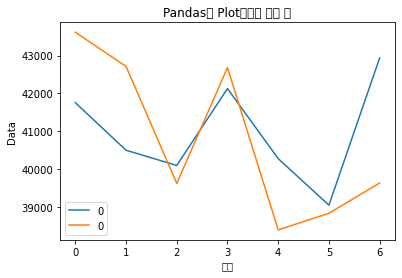

In [52]:
a_0=pd.DataFrame(actual_values_)[0:1][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[0:1][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

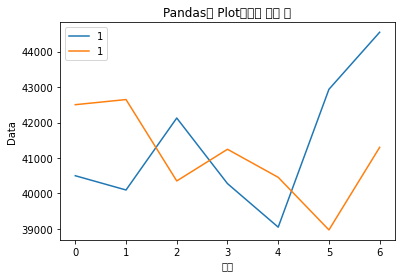

In [53]:
a_0=pd.DataFrame(actual_values_)[1:2][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[1:2][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

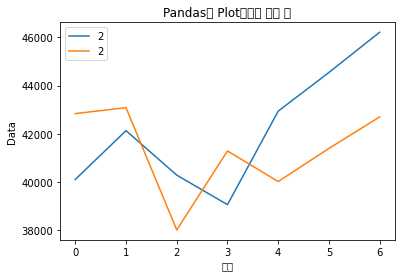

In [54]:
a_0=pd.DataFrame(actual_values_)[2:3][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[2:3][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

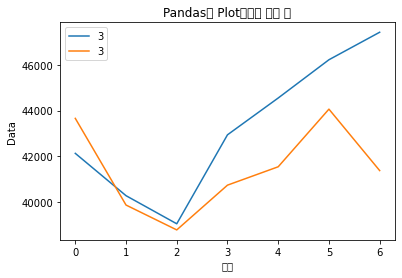

In [55]:
a_0=pd.DataFrame(actual_values_)[3:4][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[3:4][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

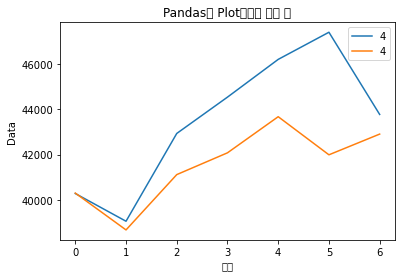

In [56]:
a_0=pd.DataFrame(actual_values_)[4:5][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[4:5][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

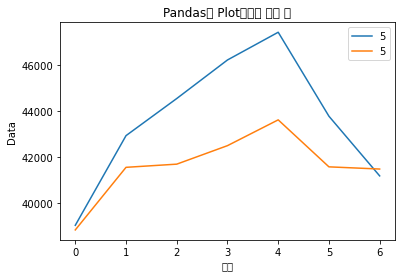

In [57]:
a_0=pd.DataFrame(actual_values_)[5:6][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[5:6][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

Text(0, 0.5, 'Data')

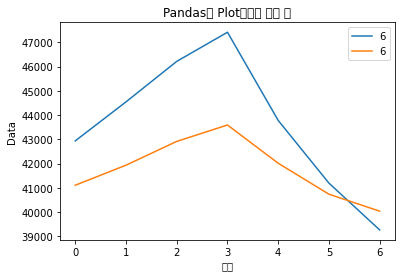

In [58]:
a_0=pd.DataFrame(actual_values_)[6:7][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[6:7][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

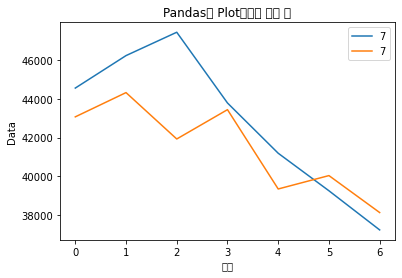

In [59]:
a_0=pd.DataFrame(actual_values_)[7:8][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[7:8][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

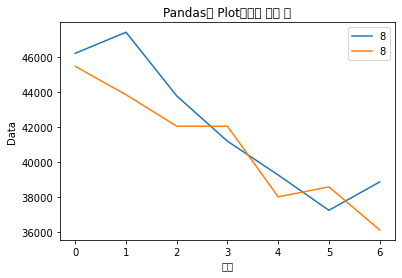

In [60]:
a_0=pd.DataFrame(actual_values_)[8:9][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[8:9][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

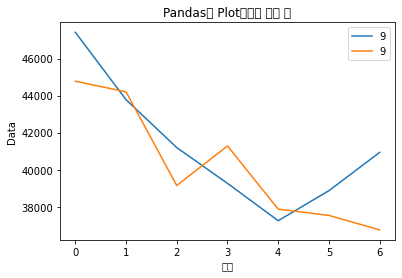

In [61]:
a_0=pd.DataFrame(actual_values_)[9:10][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[9:10][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

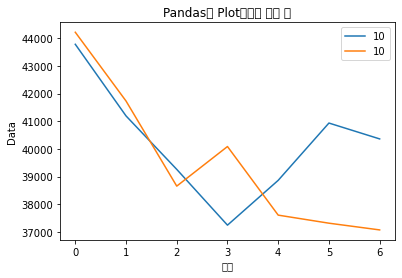

In [62]:
a_0=pd.DataFrame(actual_values_)[10:11][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[10:11][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

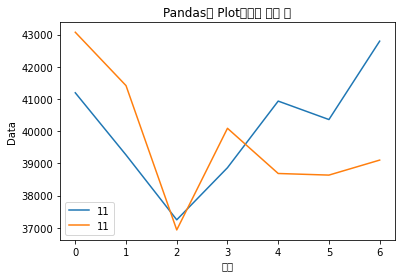

In [63]:
a_0=pd.DataFrame(actual_values_)[11:12][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[11:12][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

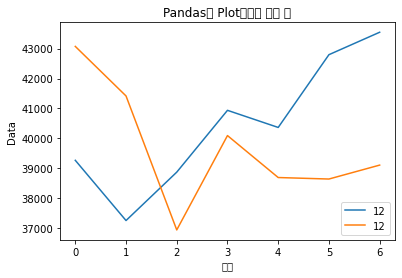

In [64]:
a_0=pd.DataFrame(actual_values_)[12:13][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[12:13][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")